<a href="https://colab.research.google.com/github/RodolpheKouyoumdjian/AssetAllocation/blob/main/AssetAllocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


[*********************100%***********************]  8 of 8 completed
Start date: 2015-06-02
End date: 2022-11-14
Execution time: 7.2125866413116455 seconds
   Sharpe Ratio  Annualized return  Annualized risk     AAPL %    AMZN %  \
0      1.134230          30.000878        26.450436  11.746585  7.943985   
1      1.134052          30.157841        26.593000   6.484787  8.465864   
2      1.133015          29.563446        26.092730   6.447104  6.914369   
3      1.132473          33.402363        29.495066   2.730582  9.802986   
4      1.123039          35.144532        31.294128   9.364186  7.696747   

      MSFT %     TSLA %      WMT %     SPY %     SHOP %       KO %  
0   9.009034  24.955948  14.551992  0.633697  17.016699  14.142061  
1   6.220799  21.154023  18.066363  1.472912  16.508787  21.626464  
2  10.502882  25.452598  16.681880  1.303117  15.841783  16.856267  
3   2.891198  31.336239  21.061515  1.694539  18.284905  12.198037  
4   2.930642  24.801838  17.964656  1.7504

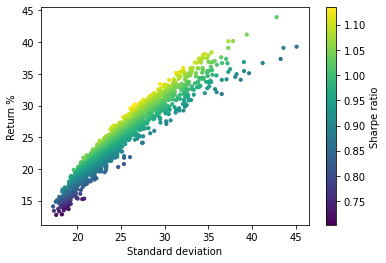

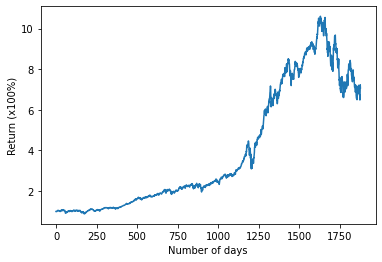

In [ ]:
import numpy as np
import pandas as pandas
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import time
import pandas as pd

start_time = time.time()
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None, 'display.max_columns', None)
today = datetime.today().strftime('%Y-%m-%d') #Today's date
StartDate = '2015-06-01' #YYYY-MM-DD format
#EndDate = '2021-07-01'
EndDate = today

# Variables
n_portfolios = 1500
mean_returns, stdev, all_h, all_sr, all_w = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

# Ticker list
assets = ["AAPL", "AMZN", "MSFT", "TSLA", "WMT", "SPY", "SHOP", "KO"]
n_assets = len(assets) # Number of assets

# Get data, percent change of close
#data = yf.download(assets, period='max').pct_change().dropna() # Most amount of data possible (earliest)
data = yf.download(assets, start=StartDate, end=EndDate).pct_change().dropna() # Personalized date range
dates = data.index.strftime('%Y-%m-%d').tolist()
n_days = len(dates)
print('Start date: ' + str(dates[0]))
print('End date: ' + str(dates[-1]))

close = np.array(data['Close']).T # Close data

# Random weight of each component of the portfolio
for _ in range(n_portfolios):
    weights = np.random.dirichlet(np.ones(n_assets), size=1) # Weight of each asset in the portfolio
    all_w = np.append(all_w, [weights])
    daily_returns = np.sum(close*weights.T, axis=0)+1 # Daily returns
    history = np.cumprod(daily_returns) # Portfolio performance
    all_h = np.append(all_h, history)
    total_return = history[-1] # Final simple return
    mean_return = np.mean(daily_returns) # Average daily return
    p_stdev = np.std(daily_returns) # Standard deviation of portfolio

    # Risk / return
    annualized_return = 100 * (total_return ** (252 / n_days)) - 100
    annualized_risk = 100 * p_stdev * (252**0.50)
    mean_returns = (np.append(mean_returns, annualized_return)) # Average return array of all portfolios
    stdev = np.append(stdev, annualized_risk)  # Standard deviation of all portfolios
    sharpe_ratio = annualized_return / annualized_risk # Risk / return metric
    all_sr = np.append(all_sr, sharpe_ratio) # Sharpe ratio for all portfolios
all_h = np.reshape(all_h, (n_portfolios, n_days))

# Execution time
end_time = time.time()
print('Execution time: ' + str(end_time - start_time) + ' seconds')

# Sorting with respect to sharpe ratio
all_w = np.reshape(all_w, (n_portfolios, n_assets))
all_sr, mean_returns, stdev = all_sr.T, mean_returns.T, stdev.T
zipped = zip(all_sr, all_w, mean_returns, stdev, all_h)
sz = sorted(zipped)
all_sr, all_w, mean_returns, stdev, all_h = zip(*sorted(zip(all_sr, all_w, mean_returns, stdev, all_h), reverse=True))
mean_returns, stdev = np.array(mean_returns), np.array(stdev)

# Creating a dataframe for all the data
all_w = 100 * np.array(all_w)
w_column_names = [i + ' %' for i in assets]
_ = np.array([all_sr, mean_returns, stdev])
df = pd.DataFrame(_, index=['Sharpe Ratio', 'Annualized return', 'Annualized risk']).T.join(pd.DataFrame(all_w, columns=w_column_names), how='right')
print(df.head())

# Efficiency of portfolio with sharpe ratio as third variable
sc = plt.scatter(stdev, mean_returns, c=all_sr, s=10)
plt.xlabel("Standard deviation")
plt.ylabel('Return %')
plt.colorbar(sc, label='Sharpe ratio')
plt.show()

plt.plot(all_h[0])
plt.xlabel("Number of days")
plt.ylabel("Return (x100%)")
plt.show()